In [2]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np

door1 = pd.read_csv("data/data_door1.txt",  sep=";", header=None)
door1 = door1.set_axis(["Timestamp", "x", "y", "z", "pressure"], axis=1, inplace=False)


In [3]:
def calculateMedian(i, variable, size):        
    start = max(i - size, 0) 
    end = min(i, len(variable)) 

    calculate_median = variable[start:end]
    calculate_median.sort()
    if(len(calculate_median) > 0): median = calculate_median[len(calculate_median)//2]
    else: median = variable[i]
        
    return median

def rolling_media(i, variable, size, variableMedian):
    median = calculateMedian(i, variable, size)
    variableMedian.append(median)
    
def cummulative_sum(i, variableMedian, gMax, gMin, drift):
        s_i = variableMedian[i] - variableMedian[i-1]
        gMax_i = max(gMax[i-1] + s_i - drift, 0)
        gMin_i = max(gMin[i-1] - s_i - drift, 0)
        gMax.append(gMax_i)
        gMin.append(gMax_i)
                
        return gMax_i, gMin_i

In [4]:
x = list(door1.x)
z = list(door1.z)
y = list(door1.y)

### MEDIAN values #####

windowSize = 100                # Size of the median window
x_median = list()   # median stored
z_median = list()
y_median = list()

#### CUSUM values #####

x_drift = 0.07              # drift: CUSUM parameter
x_threshold = 0.01          # threshold: CUSUM parameter
z_drift = 0.07
z_threshold = 0.03

x_alarms = list()           # Points where a movement change is detected
x_opening = list()          # Points when an upward movement is detected
x_closing = list()          # Points when an downward movement is detected
z_alarms = list()           
z_opening = list()          
z_closing = list()   
            
x_gMax = list([0]) # internal variables for CUSUM
x_gMin = list([0])
z_gMax = list([0])
z_gMin = list([0])


### STEP Detection ####

#alarmDetected = False
alarmInterval = 10             # Alarms closer than this will be considerated consecutive
x_alarmCounter = 0               # Counter of consecutive alarms
x_change = list()                # Cumulative alarms
z_alarmCounter = 0               
z_change = list()                


x_closingDetected = False
x_openingDetected = False
x_lastAlarm = -1                 # Index of last alarm
z_closingDetected = False
z_openingDetected = False
z_lastAlarm = -1                 


### Slope ponderation ####

x_slope = list([0])              # Storing slope
z_slope = list([0])              # Storing slope



In [5]:
for i in range(0, 5000):
    
    ### MEDIAN calculation #####
    # Calculate median of raw data     
    rolling_media(i, x, windowSize, x_median)
    rolling_media(i, z, windowSize, z_median)

    ###### CUSUM intervals #####
    # Detect growing and decreasing tendences on the median,
    # Results in a list of indexes of changes
    if(i != 0): 
        x_gMax_i, x_gMin_i = cummulative_sum(i, x_median, x_gMax, x_gMin, x_drift)
        
        x_alarmDetected = x_gMax_i > x_threshold or x_gMin_i > x_threshold
        if(x_alarmDetected): x_alarms.append(i)

        x_openingDetected = x_gMax_i > x_threshold
        if(x_openingDetected): x_opening.append(i)

        x_closingDetected = x_gMin_i > x_threshold
        if(x_closingDetected): x_closing.append(i)   
            
            
        z_gMax_i, z_gMin_i = cummulative_sum(i, z_median, z_gMax, z_gMin, z_drift)
        
        z_alarmDetected = z_gMax_i > z_threshold or z_gMin_i > z_threshold
        if(z_alarmDetected): z_alarms.append(i)

        z_openingDetected = z_gMax_i > z_threshold
        if(z_openingDetected): z_opening.append(i)

        z_closingDetected = z_gMin_i > z_threshold
        if(z_closingDetected): z_closing.append(i)  

    ### Slope ponderation ####
    # Calculate the slope of the median to ponderate with the added value in case 
    # of positive alarm. Helps define the intervals with more precision, solve errors
    # in definition and provides an aproximation of speed
    
    # (fun(i) - fun(j) / (i-j)) # i-j is constant, j = i - 1
    if(i != 0): 
        x_slope.append(x_median[i] - x_median[i-1])
        z_slope.append(z_median[i] - z_median[i-1])
        
    
    #### Step Detection #####
    # Apply ponderation an calculate cumulative movement
    
    if(x_openingDetected or x_closingDetected):
        x_alarmCounter += (1 * x_slope[i])
        x_lastAlarm = i   
    elif(x_lastAlarm > i - alarmInterval):  # Interval exceded
        x_alarmCounter += (1 * x_slope[i])
    else:
        x_alarmCounter = 0 
    x_change.append(x_alarmCounter)
    
    if(z_openingDetected or z_closingDetected):
        z_alarmCounter += (1 * z_slope[i])
        z_lastAlarm = i   
    elif(z_lastAlarm > i - alarmInterval):  # Interval exceded
        z_alarmCounter += (1 * z_slope[i])
    else:
        z_alarmCounter = 0 
    z_change.append(z_alarmCounter)
    

### TESTS

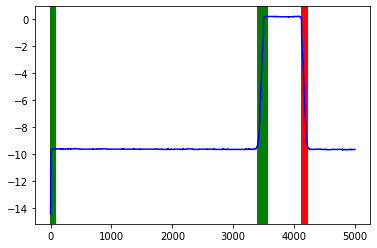

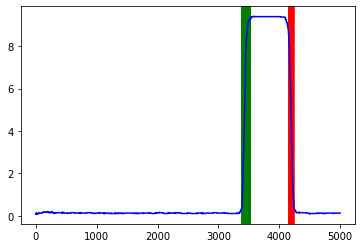

In [6]:
# Alarms detected with median
for i in x_closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in x_opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(x_median[0:50000], color="blue")

plt.show()

for i in z_closing:
    plt.axvline(x=i, color='red', linestyle='-')
for i in z_opening:
    plt.axvline(x=i, color='green', linestyle='-')

plt.plot(z_median[0:50000], color="blue")

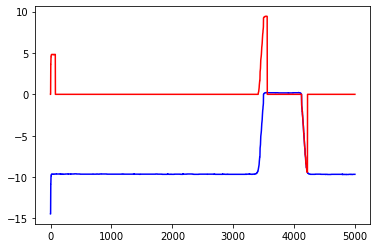

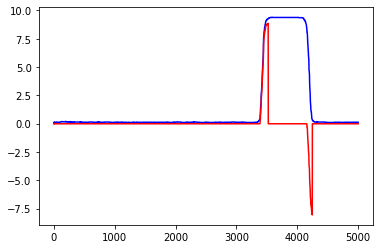

In [7]:
plt.plot(x_median[0:5000], color="blue")
plt.plot(x_change[0:5000], color="red")

plt.show()

plt.plot(z_median[0:5000], color="blue")
plt.plot(z_change[0:5000], color="red")

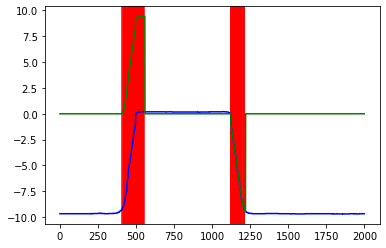

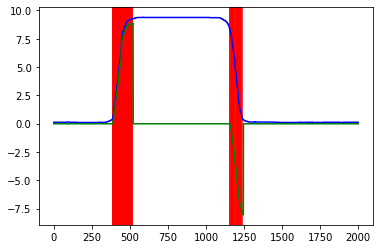

In [8]:
for i in x_alarms:
    if(i > 3000 and i < 5000):
        plt.axvline(x=i-3000, color='red', linestyle='-')
plt.plot(x_median[3000:5000], color="blue")
plt.plot(x_change[3000:5000], color="green")

plt.show()

for i in z_alarms:
    if(i > 3000 and i < 5000):
        plt.axvline(x=i-3000, color='red', linestyle='-')
plt.plot(z_median[3000:5000], color="blue")
plt.plot(z_change[3000:5000], color="green")